<a href="https://colab.research.google.com/github/yumi-xu/credit-card/blob/main/CardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn import metrics
from collections import Counter

In [ ]:
# import Data

try:
    raw_df = pd.read_csv('./raw_data.csv')
except:
    raw_df = pd.read_csv('raw_data.csv')

label_cnt = raw_df["TARGET"].value_counts().tolist()
label_cnt

[282686, 24825]

# Data imbalance check

In [ ]:
labels=["Genuine","Fraud"]

fraud_or_not = raw_df["TARGET"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=raw_df['TARGET'].value_counts(), names=labels , width=500, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

<ipython-input-8-08f472179961>:3: UserWarning:

FixedFormatter should only be used together with FixedLocator



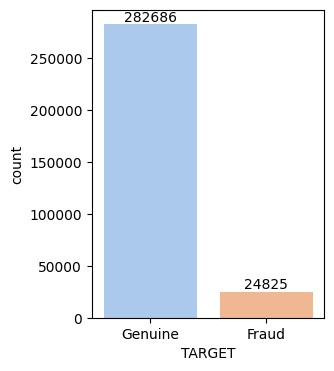

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='TARGET', hue='TARGET',data=raw_df,palette="pastel",legend=False)
ax.set_xticklabels(['Genuine', 'Fraud'])
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('TARGET.png')

# Data pre-processing

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# copy to new dataframe
df = raw_df.copy()

# drop duplications
df.drop_duplicates(inplace=True)

df = df.select_dtypes(exclude=['object'])

In [ ]:
## calculate the correlation between target and features
target_correlations = df.corr()['TARGET']
target_correlations_sorted = target_correlations.sort_values(ascending=False)

## Get the first 30 correlated features
high_corr_features = target_correlations_sorted.index[0:31]
print(target_correlations_sorted[0:31])

df_30features = df[high_corr_features].copy()
df_30features.shape

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
REG_REGION_NOT_WORK_REGION     0.006942
REG_REGION_NOT_LIVE_REGION     0.005576
FLAG_DOCUMENT_2                0.005417
FLAG_DOCUMENT_21               0.003709


(307511, 31)

In [ ]:
## Look into the number of NaN values in the each correlated features
nan_counts = df_30features.isna().sum()
nan_counts

TARGET                              0
DAYS_BIRTH                          0
REGION_RATING_CLIENT_W_CITY         0
REGION_RATING_CLIENT                0
DAYS_LAST_PHONE_CHANGE              1
DAYS_ID_PUBLISH                     0
REG_CITY_NOT_WORK_CITY              0
FLAG_EMP_PHONE                      0
REG_CITY_NOT_LIVE_CITY              0
FLAG_DOCUMENT_3                     0
DAYS_REGISTRATION                   0
OWN_CAR_AGE                    202929
LIVE_CITY_NOT_WORK_CITY             0
DEF_30_CNT_SOCIAL_CIRCLE         1021
DEF_60_CNT_SOCIAL_CIRCLE         1021
FLAG_WORK_PHONE                     0
AMT_REQ_CREDIT_BUREAU_YEAR      41519
CNT_CHILDREN                        0
CNT_FAM_MEMBERS                     2
OBS_30_CNT_SOCIAL_CIRCLE         1021
OBS_60_CNT_SOCIAL_CIRCLE         1021
REG_REGION_NOT_WORK_REGION          0
REG_REGION_NOT_LIVE_REGION          0
FLAG_DOCUMENT_2                     0
FLAG_DOCUMENT_21                    0
LIVE_REGION_NOT_WORK_REGION         0
AMT_REQ_CRED

In [ ]:
## Fill NaN with 0 according to features definations
df_30features.fillna(0, inplace=True)

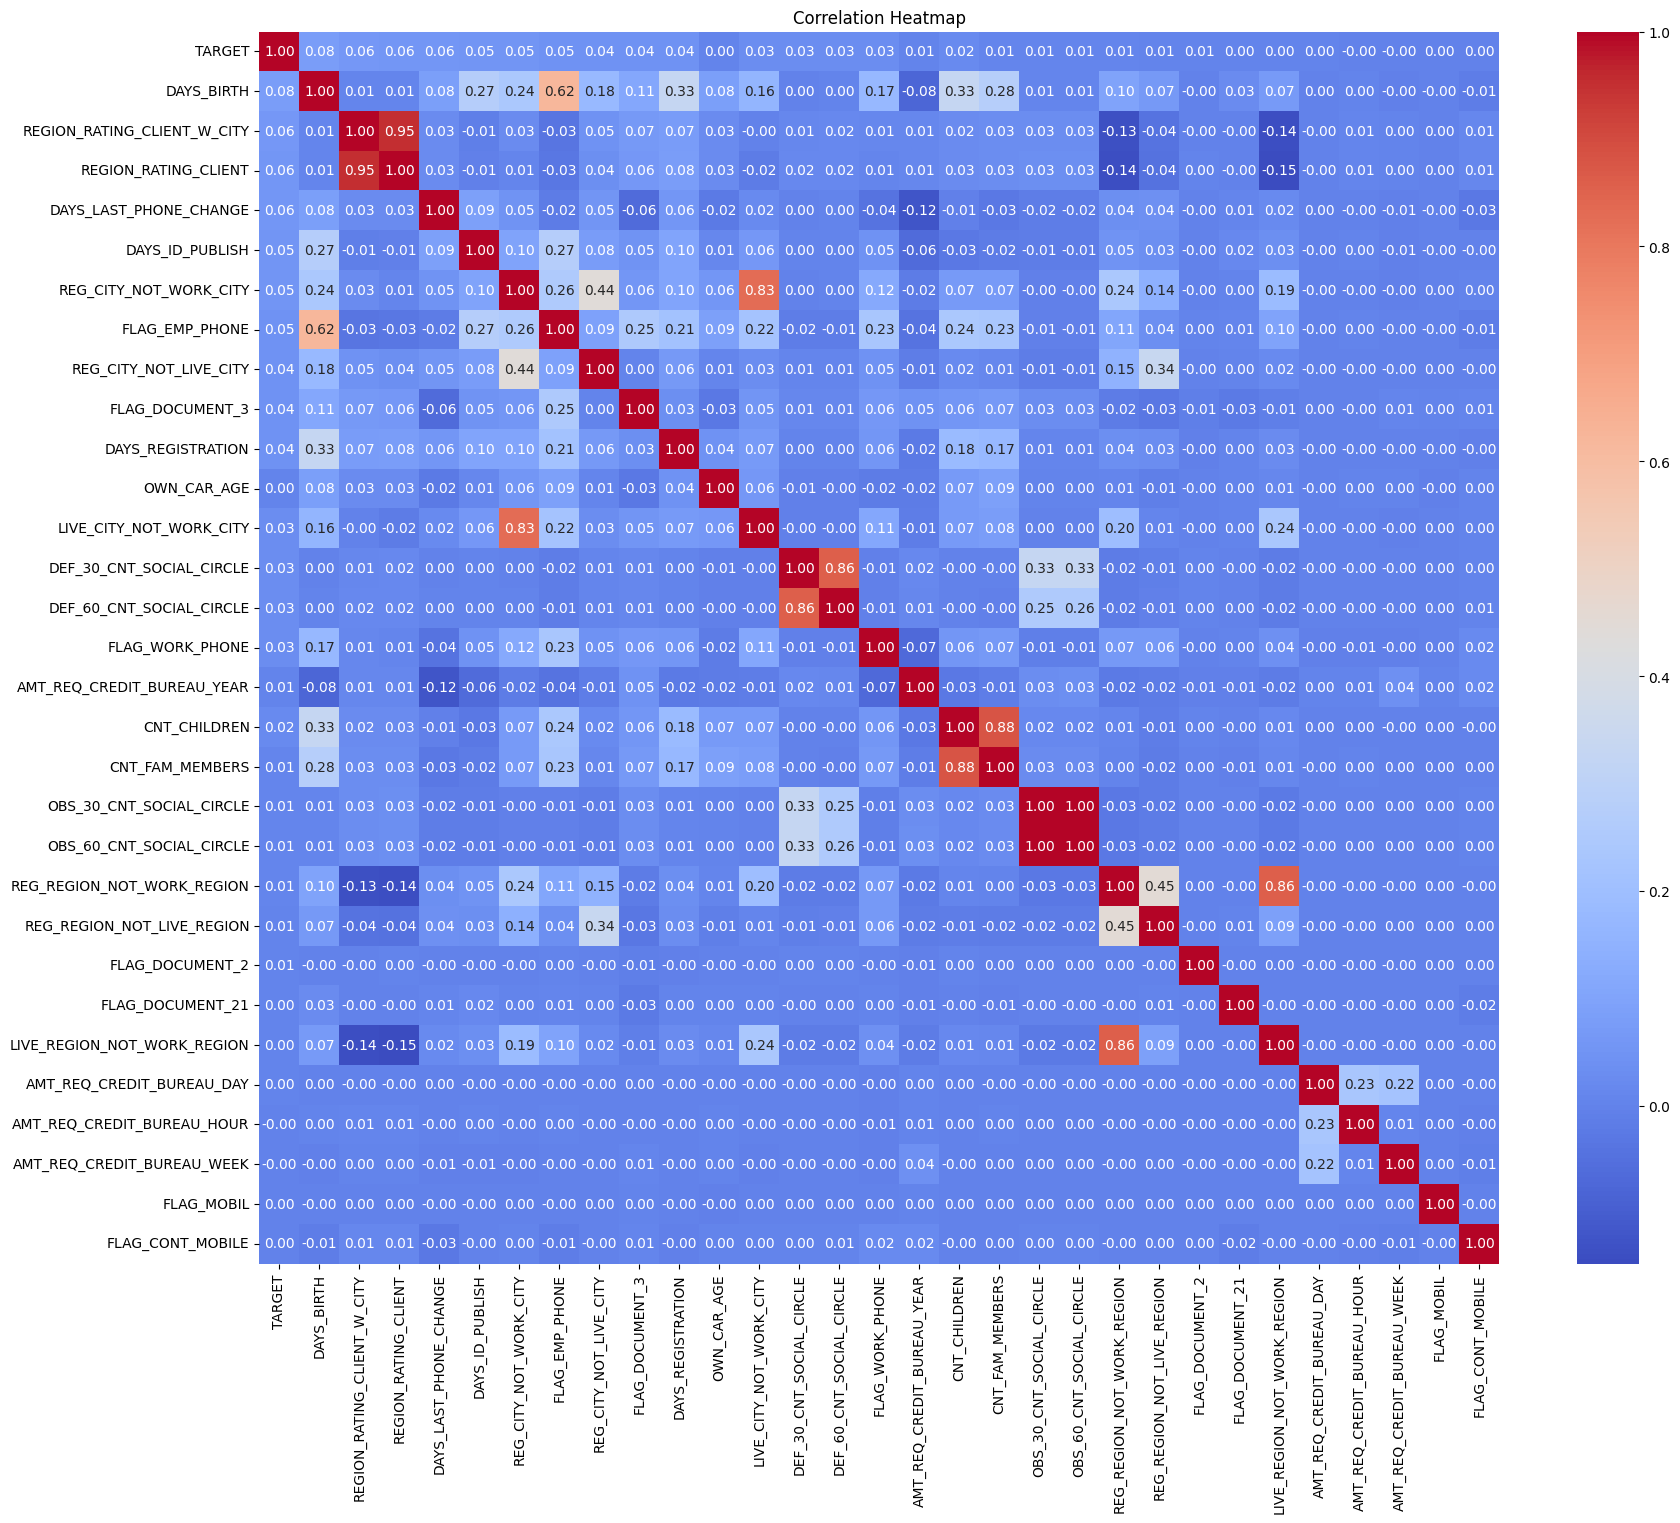

In [ ]:
# Calculate the correlation bewtween selected 30 features
correlation_matrix = df_30features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

## Only a few highly correlated features are found, can keep it.

In [ ]:
# description of the data
# df_30features.describe()

# describe shape of the data
df_30features.shape

# Target counts
df_30features['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [ ]:
df_30features.to_csv('data_30features.csv', index=False)

# Sampling

In [ ]:
# import 30 Feature Data
try:
    df_30features = pd.read_csv('./data_30features.csv')
except:
    df_30features = pd.read_csv('data_30features.csv')

In [ ]:
# Top 30 features
X = df_30features.drop('TARGET', axis=1)
y = df_30features['TARGET']

# Select only first 10 features
# X = df_30features[df_30features.columns[:12]].drop('TARGET', axis=1)
# y = df_30features['TARGET']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.4, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating function for Standard Scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

col_names = df_30features.columns[1:]
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)



# Random Oversampling

In [ ]:
# Finding Best parameters of SOMTE via RandomForestClassifier using GridSearchCV
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=40)

X_rd_over, y_rd_over = ros.fit_resample(X_train, y_train)


In [ ]:
print('Genuine:', y_rd_over.value_counts()[0], '/', round(y_rd_over.value_counts()[0]/len(y_rd_over) * 100,2), '% of the dataset')
print('Frauds:', y_rd_over.value_counts()[1], '/',round(y_rd_over.value_counts()[1]/len(y_rd_over) * 100,2), '% of the dataset')

Genuine: 169611 / 50.0 % of the dataset
Frauds: 169611 / 50.0 % of the dataset


#  SMOTE

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def SMOTE_sample(X, y, k=5, oversampling_ratio=1.0):
    """
    Perform SMOTE over-sampling on the minority class samples.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        Minority class samples.
    y : array-like, shape (n_samples,)
        Corresponding class labels.
    k : int, optional (default=5)
        Number of nearest neighbors to consider.
    oversampling_ratio : float, optional (default=1.0)
        Ratio of the number of synthetic samples to the number of original minority samples.

    Returns:
    X_resampled : array-like, shape (n_samples_new, n_features)
        Synthetically generated samples.
    y_resampled : array-like, shape (n_samples_new,)
        Corresponding class labels for the synthetic samples.
    """
    # Find the minority class samples
    minority_samples = X[y == 1]

    # Compute the number of synthetic samples to generate
    n_minority_samples = len(minority_samples)
    n_synthetic_samples = int(n_minority_samples * oversampling_ratio)

    # Initialize arrays to store synthetic samples and their labels
    synthetic_samples = np.zeros((n_synthetic_samples, X.shape[1]))
    synthetic_labels = np.ones(n_synthetic_samples)  # Assuming minority class label is 1

    # Fit k-nearest neighbors model on the minority samples
    knn = NearestNeighbors(n_neighbors=k+1).fit(minority_samples)

    # Generate synthetic samples
    for i in range(n_synthetic_samples):
        # Randomly choose a minority sample
        index = np.random.randint(0, n_minority_samples)
        sample = minority_samples[index]

        # Find k-nearest neighbors
        _, neighbors = knn.kneighbors(sample.reshape(1, -1))
        neighbors = neighbors.flatten()[1:]  # Exclude the sample itself

        # Randomly choose one of the neighbors
        nn_index = np.random.choice(neighbors)
        nn = minority_samples[nn_index]

        # Generate synthetic sample
        gap = np.random.random_sample(X.shape[1])
        synthetic_samples[i] = sample + gap * (nn - sample)

    # Combine original and synthetic samples
    X_resampled = np.vstack((X, synthetic_samples))
    y_resampled = np.hstack((y, synthetic_labels))

    return X_resampled, y_resampled


In [ ]:
#  Finding Best parameters of SOMTE via RandomForestClassifier using GridSearchCV
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=42)

X_SMOTE_over, y_SMOTE_over = sm.fit_resample(X_train, y_train)

In [ ]:
print('Genuine:', y_SMOTE_over.value_counts()[0], '/', round(y_SMOTE_over.value_counts()[0]/len(y_SMOTE_over) * 100,2), '% of the dataset')
print('Frauds:', y_SMOTE_over.value_counts()[1], '/',round(y_SMOTE_over.value_counts()[1]/len(y_SMOTE_over) * 100,2), '% of the dataset')

Genuine: 169611 / 50.0 % of the dataset
Frauds: 169611 / 50.0 % of the dataset


# Logstic Regression

In [ ]:
import numpy as np

def sigmoid(z):
    """
    Compute the sigmoid function.

    Parameters:
    z : array-like
        Input to the sigmoid function.

    Returns:
    array-like
        Output of the sigmoid function.
    """
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, y, learning_rate=0.01, num_iterations=1000, verbose=False):
    """
    Perform logistic regression optimization.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        Training data.
    y : array-like, shape (n_samples,)
        Target labels.
    learning_rate : float, optional (default=0.01)
        Learning rate for gradient descent.
    num_iterations : int, optional (default=1000)
        Number of iterations for gradient descent.
    verbose : bool, optional (default=False)
        If True, print progress during optimization.

    Returns:
    array-like
        Learned parameters.
    """
    # Initialize parameters
    m, n = X.shape
    theta = np.zeros(n)

    # Perform gradient descent
    for i in range(num_iterations):
        # Calculate hypothesis
        z = np.dot(X, theta)
        h = sigmoid(z)

        # Calculate gradient and update parameters
        gradient = np.dot(X.T, (h - y)) / m
        theta -= learning_rate * gradient

        # Print progress
        if verbose and i % 100 == 0:
            cost = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
            print(f"Iteration {i}: Cost = {cost}")

    return theta


# Decision Tree

In [ ]:
import numpy as np

class DecisionTree:
    """
    A simple decision tree classifier.

    Parameters:
    max_depth : int, optional (default=None)
        The maximum depth of the tree.
    min_samples_split : int, optional (default=2)
        The minimum number of samples required to split an internal node.
    """
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def _entropy(self, y):
        """
        Calculate the entropy of the target labels.

        Parameters:
        y : array-like
            Target labels.

        Returns:
        float
            Entropy value.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

    def _information_gain(self, X, y, feature_index, split_value):
        """
        Calculate the information gain.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.
        y : array-like
            Target labels.
        feature_index : int
            Index of the feature to split on.
        split_value : float
            Value to split the feature on.

        Returns:
        float
            Information gain value.
        """
        # Split the dataset
        left_mask = X[:, feature_index] <= split_value
        right_mask = ~left_mask
        left_y, right_y = y[left_mask], y[right_mask]

        # Calculate weighted entropy
        parent_entropy = self._entropy(y)
        left_entropy = self._entropy(left_y)
        right_entropy = self._entropy(right_y)
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        child_entropy = left_weight * left_entropy + right_weight * right_entropy

        # Calculate information gain
        return parent_entropy - child_entropy

    def _find_best_split(self, X, y):
        """
        Find the best split for the dataset.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.
        y : array-like
            Target labels.

        Returns:
        dict
            Dictionary containing the index of the best feature to split on and the corresponding split value.
        """
        best_gain = -1
        best_feature_index = -1
        best_split_value = None

        for feature_index in range(X.shape[1]):
            unique_values = np.unique(X[:, feature_index])
            for split_value in unique_values:
                gain = self._information_gain(X, y, feature_index, split_value)
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_split_value = split_value

        return {'feature_index': best_feature_index, 'split_value': best_split_value}

    def fit(self, X, y):
        """
        Fit the decision tree classifier.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.
        y : array-like
            Target labels.
        """
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """
        Recursively grow the decision tree.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.
        y : array-like
            Target labels.
        depth : int
            Current depth of the tree.

        Returns:
        dict
            Dictionary representing the decision tree.
        """
        if depth == self.max_depth or len(np.unique(y)) == 1 or len(y) < self.min_samples_split:
            return {'leaf': True, 'class': np.argmax(np.bincount(y))}

        split = self._find_best_split(X, y)
        left_mask = X[:, split['feature_index']] <= split['split_value']
        right_mask = ~left_mask

        left_subtree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return {'leaf': False, 'split_feature': split['feature_index'], 'split_value': split['split_value'],
                'left': left_subtree, 'right': right_subtree}

    def _predict_sample(self, tree, sample):
        """
        Predict the class for a single sample.

        Parameters:
        tree : dict
            Dictionary representing the decision tree.
        sample : array-like
            Single sample to predict.

        Returns:
        int
            Predicted class label.
        """
        if tree['leaf']:
            return tree['class']
        else:
            if sample[tree['split_feature']] <= tree['split_value']:
                return self._predict_sample(tree['left'], sample)
            else:
                return self._predict_sample(tree['right'], sample)

    def predict(self, X):
        """
        Predict class labels for samples.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.

        Returns:
        array-like
            Predicted class labels.
        """
        predictions = []
        for sample in X:
            predictions.append(self._predict_sample(self.tree, sample))
        return np.array(predictions)


# Random Forest

In [ ]:
import numpy as np

class RandomForest:
    """
    A Random Forest classifier.

    Parameters:
    n_estimators : int, optional (default=100)
        The number of decision trees in the forest.
    max_depth : int, optional (default=None)
        The maximum depth of the decision trees.
    min_samples_split : int, optional (default=2)
        The minimum number of samples required to split an internal node.
    """
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.forest = []

    def fit(self, X, y):
        """
        Fit the Random Forest classifier.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.
        y : array-like
            Target labels.
        """
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            indices = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[indices], y[indices])
            self.forest.append(tree)

    def predict(self, X):
        """
        Predict class labels for samples.

        Parameters:
        X : array-like, shape (n_samples, n_features)
            Feature matrix.

        Returns:
        array-like
            Predicted class labels.
        """
        predictions = np.zeros((len(X), self.n_estimators), dtype=int)
        for i, tree in enumerate(self.forest):
            predictions[:, i] = tree.predict(X)
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


smote_pipeline_rf = make_pipeline(SMOTE(sampling_strategy=1, k_neighbors=5, random_state=13), RandomForestClassifier(n_estimators=100, random_state=13))
kf = StratifiedKFold(n_splits=3, shuffle=False)
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}

smote_rf = GridSearchCV(smote_pipeline_rf, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
smote_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=13,
                                              sampling_strategy=1)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [ ]:
print('Best parameters:', smote_rf.best_params_)
print('Best score:', smote_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}
Best score: 0.5013091641490433


# Model Training

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [ ]:
def ml_model(X_train, X_test, y_train, y_test):

    # MLA = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=200, random_state=13)]
    MLA = [LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100, random_state=13),
          DecisionTreeClassifier(max_depth=15, min_samples_split=20, min_samples_leaf=20, criterion='gini', random_state=13),
          RandomForestClassifier(n_estimators=84,
                                  max_depth=10,
                                  min_samples_split=9,
                                  min_samples_leaf=10,
                                  random_state=13)]

    # XGBClassifier()

    MLA_columns = []
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    row_index = 0
    for alg in MLA:
        # predicted = alg.fit(X_train, y_train).predict(X_test)
        alg.fit(X_train, y_train)
        threshold = 0.5

        proba_train = alg.predict_proba(X_train)[:, 1]
        predicted_train = (proba_train > threshold).astype(int)

        proba = alg.predict_proba(X_test)[:, 1]
        predicted = (proba > threshold).astype(int)

        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index,'Model Name'] = MLA_name
        MLA_compare.loc[row_index, 'Train Accuracy'] = round(accuracy_score(y_train, predicted_train), 2)
        MLA_compare.loc[row_index, 'Test Accuracy'] = round(accuracy_score(y_test, predicted), 2)
        MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),2)
        MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),2)
        MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted),2)
        row_index+=1

    MLA_compare.sort_values(by = ['Recall'], ascending = False, inplace = True)
    return MLA_compare

In [ ]:
#original
ml_model(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.92,0.92,0.0,0.0,0.00
1,DecisionTreeClassifier,0.92,0.92,0.2,0.0,0.01
2,RandomForestClassifier,0.92,0.92,0.0,0.0,0.00


In [ ]:
# randomoversampling
ml_model(X_rd_over, X_test, y_rd_over, y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.60,0.60,0.12,0.61,0.20
2,RandomForestClassifier,0.65,0.63,0.12,0.57,0.20
1,DecisionTreeClassifier,0.71,0.65,0.11,0.46,0.17


In [ ]:
# smoteoversampling
ml_model(X_SMOTE_over, X_test, y_SMOTE_over, y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
1,DecisionTreeClassifier,0.82,0.14,0.08,0.93,0.15
2,RandomForestClassifier,0.78,0.21,0.09,0.91,0.16
0,LogisticRegression,0.60,0.60,0.12,0.60,0.19


In [ ]:
## Decision Tree Train Scores

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

proba = dt.predict_proba(X_train)[:, 1]

threshold = 0.1

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100))

Accuracy: 100.00%, Precision: 100.00%, Recall: 100.00%


In [ ]:
## Decision Tree Test Scores

proba = dt.predict_proba(X_test)[:, 1]
--
threshold = 0.1

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%,f1: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100,f1 *100))

SyntaxError: invalid syntax (<ipython-input-47-8757a7b8ea0c>, line 4)

In [ ]:
## Random Forest Train Scores

rf =  RandomForestClassifier(max_depth = 4, n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

proba = rf.predict_proba(X_train)[:, 1]

threshold = 0.1

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100))

Accuracy: 81.24%, Precision: 14.90%, Recall: 28.09%


In [ ]:
## Random Forest Test Scores

proba = rf.predict_proba(X_test)[:, 1]

threshold = 0.1

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%,f1: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100,f1 *100))

Accuracy: 81.21%, Precision: 14.49%, Recall: 27.08%,f1: 18.88%


In [ ]:
## Random Forest rd Train Scores

rf =  RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X_rd_over, y_rd_over)

proba = rf.predict_proba(X_rd_over)[:, 1]

threshold = 0.10

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_rd_over, y_pred)
precision = precision_score(y_rd_over, y_pred)
recall = recall_score(y_rd_over, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100))


Accuracy: 96.37%, Precision: 93.22%, Recall: 100.00%


In [ ]:
## Random Forest RD Test Scores

proba = rf.predict_proba(X_test)[:, 1]

threshold = 0.10

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%,f1: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100,f1 *100))

Accuracy: 58.82%, Precision: 10.19%, Recall: 52.51%,f1: 17.07%


In [ ]:
## Random Forest SMOTE Train Scores

rf =  RandomForestClassifier()
rf.fit(X_SMOTE_over, y_SMOTE_over)

proba = rf.predict_proba(X_SMOTE_over)[:, 1]

threshold = 0.10

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_SMOTE_over, y_pred)
precision = precision_score(y_SMOTE_over, y_pred)
recall = recall_score(y_SMOTE_over, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100))

Accuracy: 90.72%, Precision: 84.34%, Recall: 100.00%


In [ ]:
## Random Forest SMOTE Test Scores

proba = rf.predict_proba(X_test)[:, 1]

threshold = 0.10

y_pred = (proba > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%,f1: {:.2f}%".format(
    accuracy * 100, precision * 100, recall * 100,f1 *100))

Accuracy: 8.33%, Precision: 8.09%, Recall: 99.92%,f1: 14.96%


In [ ]:
lg = LogisticRegression(C=1.0, penalty='l2',
                        solver='liblinear',
                        max_iter=100,
                        random_state=13)

dt = DecisionTreeClassifier(max_depth=15,
                            min_samples_split=20,
                            min_samples_leaf=20,
                            criterion='gini',
                            random_state=13)

rf = RandomForestClassifier(n_estimators=84,
                                  max_depth=10,
                                  min_samples_split=9,
                                  min_samples_leaf=10,
                                  random_state=13)

In [ ]:
def roc_auc_plot(model):
  model = model.fit(X_train, y_train)
  model_name = type(model).__name__
  # Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
  proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, proba)

  # Calculate the Area Under the ROC Curve (AUC)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title(f'{model_name} ROC Curve')
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

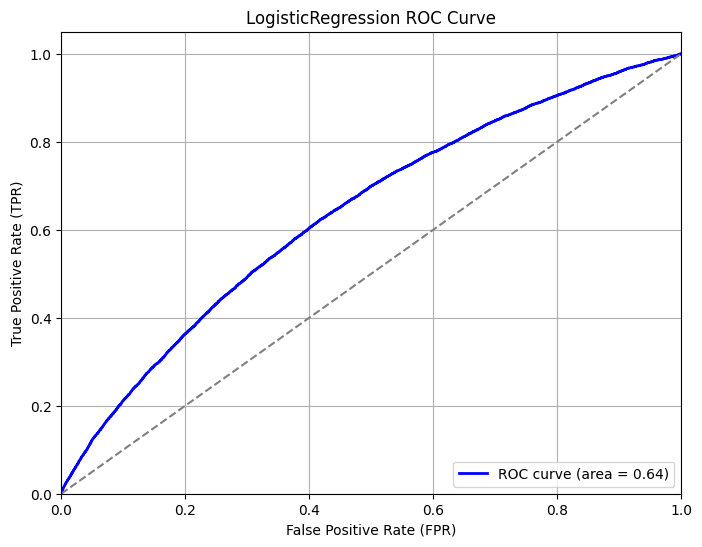

In [ ]:
roc_auc_plot(lg)

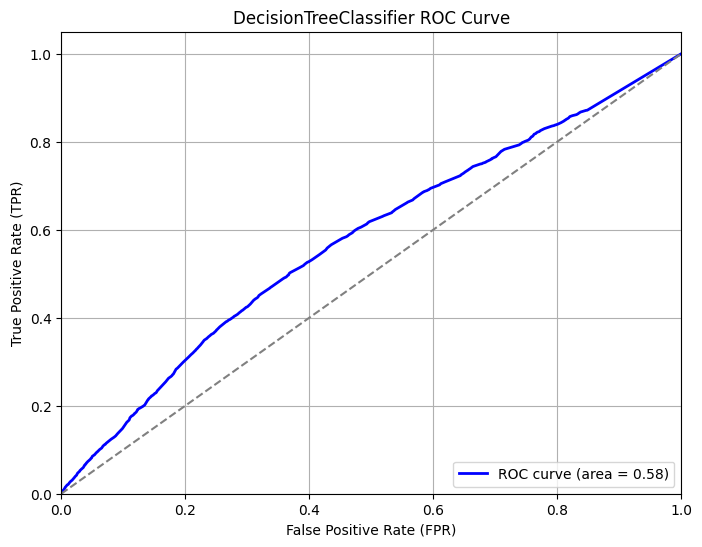

In [ ]:
roc_auc_plot(dt)

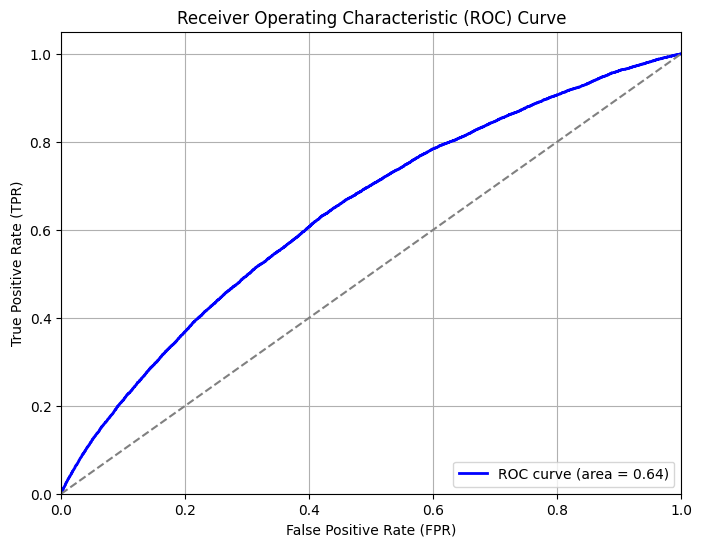

In [ ]:
roc_auc_plot(rf)